In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

In [2]:
# Note; 2013-2014 file has dates formatted differently.
# To account for this we apply pd_datetime to the data one year at a time below, it can handle the different formats individually
FILE_YEAR_RANGES = ['2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021_2022', '2022_2023']

DATA_DIRECTORY = 'external/USGS/Alaska Science Center/gulfWatch_intertidalTemperature'

loaded_dataframes = []
for year_range in FILE_YEAR_RANGES:
  file_name = f'{DATA_DIRECTORY}/Block04_KBAY/Intertidal_Temperature_KBAY_{year_range}.csv'
  year_df = pd.read_csv(file_name)
  year_df['dt'] = pd.to_datetime(year_df['date'] + ' ' + year_df['time'])
  loaded_dataframes.append(year_df)
df_all_years = pd.concat(loaded_dataframes)

# I think this should be Anchorage but I was having issues with daylight savings time
index_all_years = pd.DatetimeIndex(df_all_years['dt']).tz_localize('UTC')
df_all_years.set_index(index_all_years, inplace=True)
df_all_years.sort_index(inplace=True)

df_all_years.drop(['date','dt','time'], axis=1, inplace=True) # these are represented by the index now, unneeded
df_all_years.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1295463 entries, 2012-06-06 13:00:00+00:00 to 2023-05-21 06:00:00+00:00
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   block        1295463 non-null  object 
 1   site         1295463 non-null  object 
 2   sensor       1295463 non-null  object 
 3   HOBO_ID      1295463 non-null  int64  
 4   tide_height  1295463 non-null  float64
 5   position     1295463 non-null  object 
 6   tidelevl     1111140 non-null  float64
 7   exposure     1295463 non-null  object 
 8   temperature  1295463 non-null  float64
 9   Tidelevl     184323 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 108.7+ MB


In [3]:
# Get the value counts
sensor_entry_counts = df_all_years['sensor'].value_counts()
sensor_with_most_data = sensor_entry_counts.idxmax()
num_entries = sensor_entry_counts.max()

print(f"The sensor named '{sensor_with_most_data}' has the most entries; {num_entries}.")

The sensor named 'Outside_Bch_0.5a' has the most entries; 175698.


In [12]:
# narrow data to just that sensor and copy since we're going to do some analysis
df_sensor = df_all_years[df_all_years['sensor'] == sensor_with_most_data].copy()
df_sensor['day_of_year'] = df_sensor.index.strftime('%j').astype(int)  # Use day of the year as a number (1-366)

daily_maxes_top_decile = df_sensor['temperature'].resample('D').max().quantile(0.9)

daily_avg_temp = df_sensor.groupby('day_of_year')['temperature'].mean()
top_tenth_temp = df_sensor.groupby('day_of_year')['temperature'].quantile(0.9)


In [13]:
daily_maxes_top_decile

16.2936

In [94]:
def plot_with_mean_and_decile(data_range, size, title, ylim=(-10, 35), include_legend=False):
    start, end = data_range.index.min(), data_range.index.max()

    # Plot each year's temperatures from original data
    plt.figure(figsize=size)
    plt.plot(data_range.index, data_range, label="Recorded Temperature", color='blue', alpha=0.65)
    
    plt.xlim(start, end)
    if ylim:
        plt.ylim(ylim)
    
    plt.axhline(y=daily_maxes_top_decile, color='r', linestyle='--', label='90th Percentile Temperature')

    # Create a full date range for all years in one go
    full_dates = pd.date_range(start=start.strftime('%Y-01-01'), end=end.strftime('%Y-12-31'))
    
    # Map day_of_year to these dates, handling leap years
    mean_temps = full_dates.dayofyear.map(daily_avg_temp)

    plt.plot(full_dates, mean_temps, color="black", linewidth=2, label="Average Temperature")

    plt.title(title)
    
    plt.ylabel('Temperature (°C)')
    
    plt.grid(True, which='both')  # 'both' applies to major and minor ticks
    
    if include_legend:
        plt.legend(loc='upper right')
    
    plt.tight_layout()


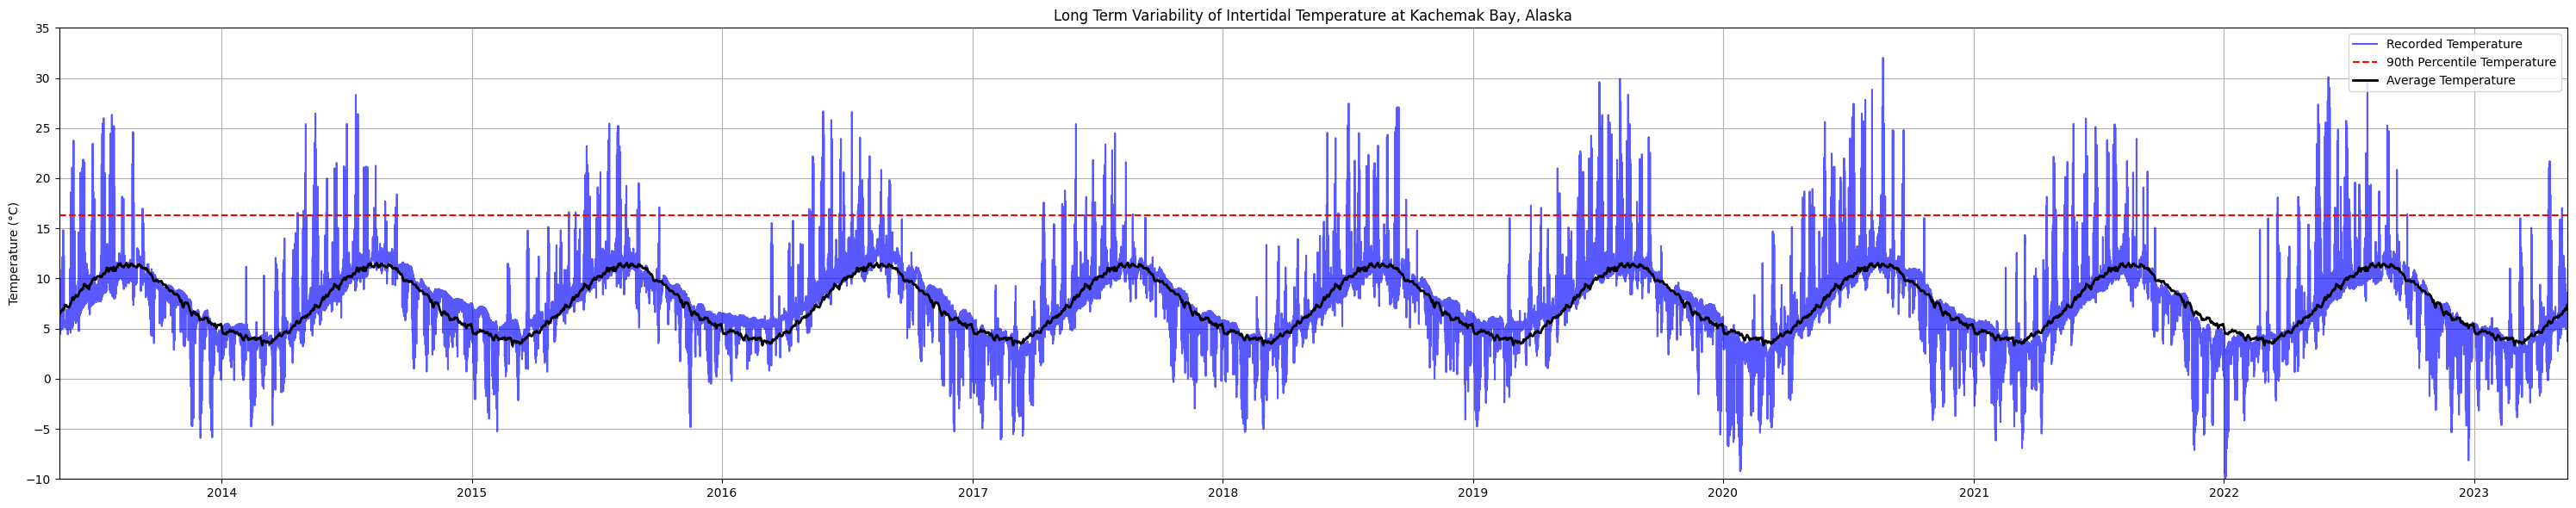

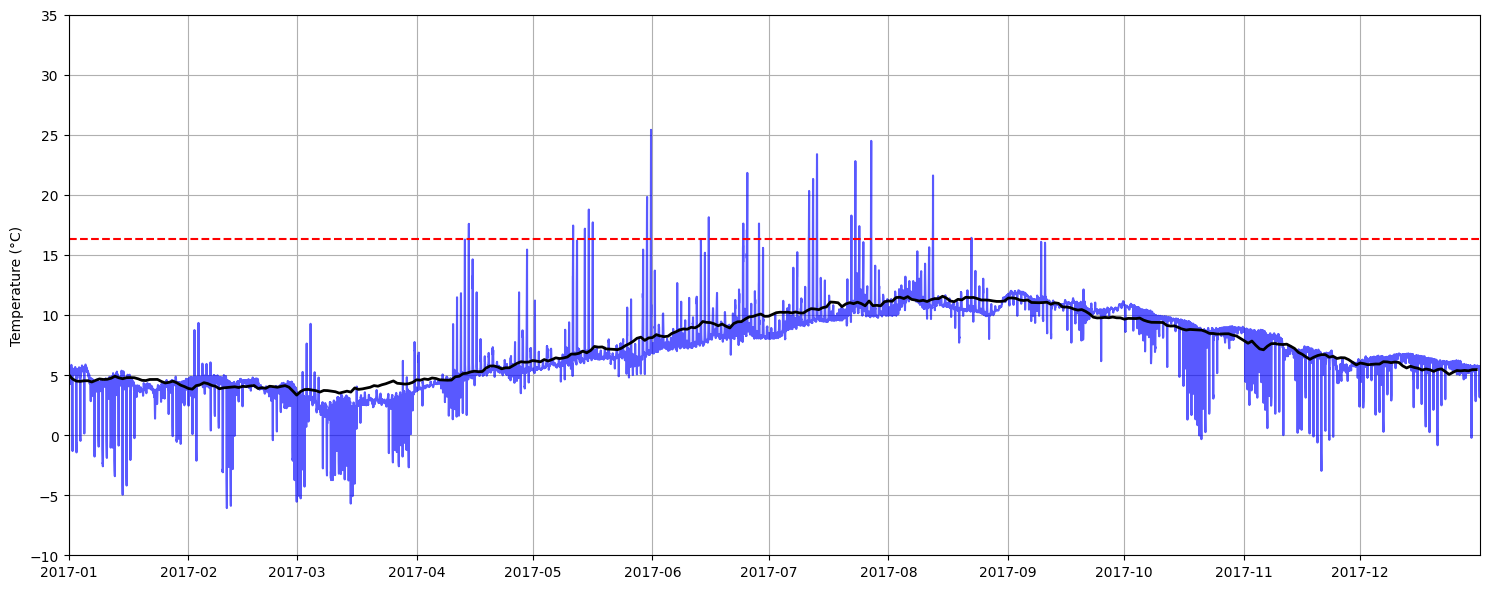

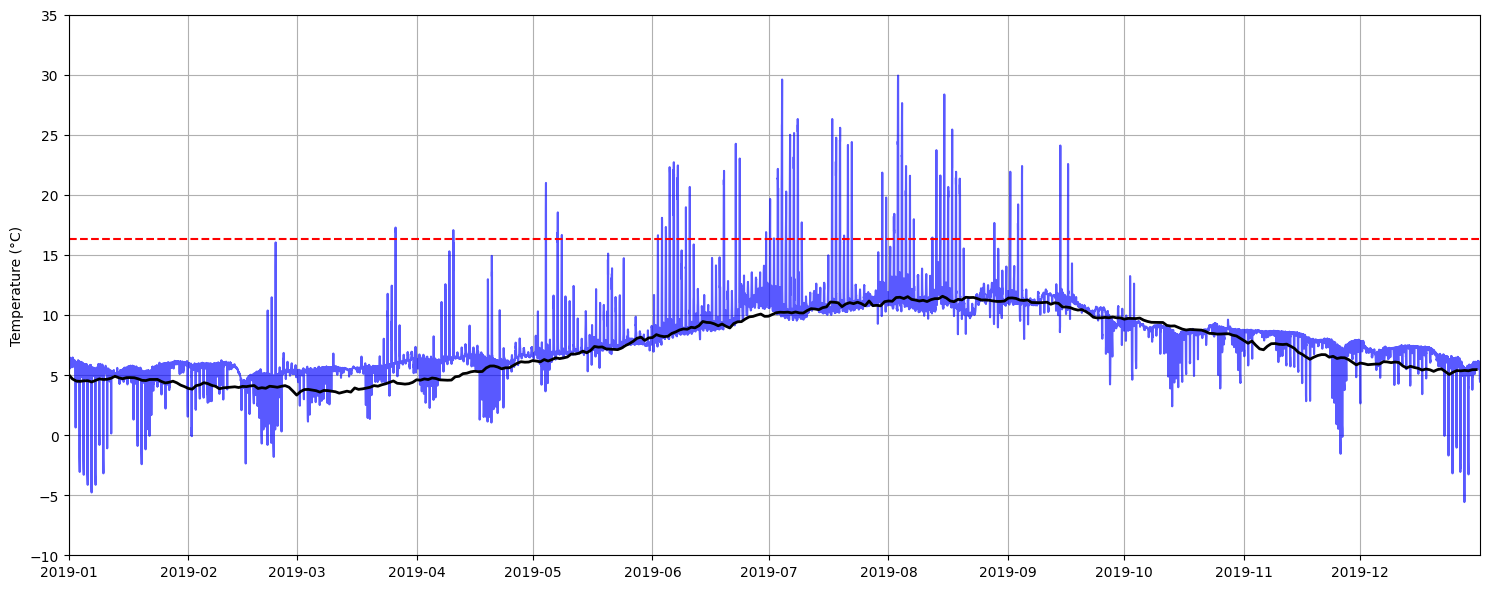

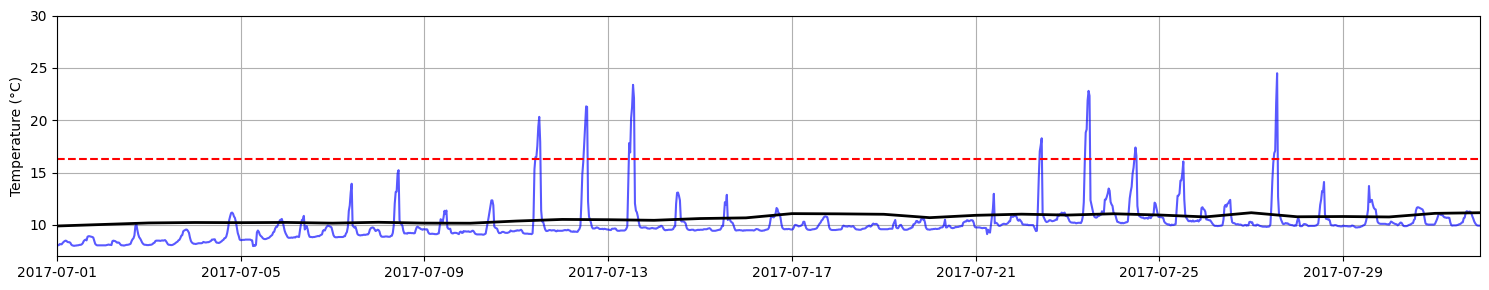

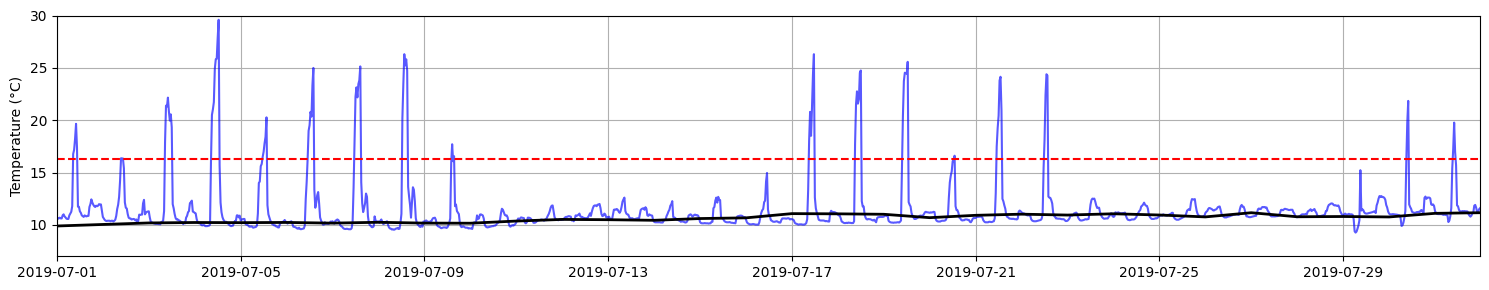

In [95]:
sensor_all_years = df_sensor['temperature']


plot_with_mean_and_decile(sensor_all_years, (30, 6), 'Long Term Variability of Intertidal Temperature at Kachemak Bay, Alaska', include_legend=True)
plot_with_mean_and_decile(sensor_all_years['2017'], (15, 6), '')
plot_with_mean_and_decile(sensor_all_years['2019'], (15, 6), '')
plot_with_mean_and_decile(sensor_all_years['2017-07'], (15, 3), '', ylim=(7, 30))
plot_with_mean_and_decile(sensor_all_years['2019-07'], (15, 3), '', ylim=(7, 30))
plt.show()


In [54]:

# # Generate a monthly date range from January 2013 to December 2020
# date_range = pd.date_range(start='2013-01-01', end='2022-12-31', freq='4ME', tz="UTC")

# # Plot each month's data
# for start in date_range:
#     end = start + pd.offsets.MonthEnd(4)
#     monthly_data = sensor_all_years[start:end]

#     if not monthly_data.empty:
#         plot_with_mean_and_decile(monthly_data)  # Assuming this function sets up the plot
#         plt.title(f'Temperature Plot: {start.strftime("%Y-%m")}')
#         plt.show()
